![](/pictures/portfolio-optimisation.png)

::: {.callout-caution}
## In Construction
Thanks for popping by; please note that this article is still in construction. 
:::

## Introduction

**Harry Markowitz** is one of the (if not "the") fathers of modern portfolio construction and his seminal paper Portfolio Selection [^1] has driven an entire research stream. 

The **intuition** behind this paper is that one can combine the information gathered on expected returns, risks and diversification of various assets or asset classes with a view to optimise the risk-return profile of a given portfolio.

In practice, we typically find a limited stability of the portfolios generated using this approach, especially due the high sensitivity of the portfolio to the expected returns; nonetheless, the insights it provides are very useful and it's a perfect start to see the impact of risk and diversification.

For this article, we will mostly rely on a fantastic Python library, PyPortfolioOpt [^2] which will do the optimisation heavy lifting for us.



## Setup

### Loading Libraries

The main library to load here is indeed **PyPortfolioOpt**, and we will rely extensively on it in this article. 

We need the following tools as well:

- **Pandas**: load, filter, sort and pretty much all data wrangling operations;
- **Numpy**: provides most matrix and advanced numerical operations; this library is the calculation backbone for pandas;
- **Matplotlib**: the *de facto* reference library to draw scientific charts;
- **yfinance**: a very handy library to access many different online databases, including Yahoo Finance.

In [1]:
#collapse-hide
import numpy as np 
import pandas_datareader.data as web_reader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import yfinance as yf

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

### Misc Parameters

In the code below, we set some variables to adjust the jupyter loo

In [2]:
#collapse-hide
# Note that this change the decimals places inside Jupyter, but not on the website
pd.options.display.float_format = '{:,.1f}'.format

## Defining our Investable Universe

First and foremost, we need to define our **Investable Universe** i.e. the set of asset classes that we will allow in our portfolio. 

Many investors would typically think about single stocks, but on my side, I am typically looking at well diversified portfolios. Moreover, I am typically looking Long Term Investing, and as such, Indices, diversified portfolio or ETFs are in focus for me. 

Speaking about asset classes, we need some ETFs to analyse!

> "Important: Please bear in mind this article if purely for pedagogical purpose and should by no mean be understood as a recommendation or advice. Investing brings risk and in particular risk of loss of capital. I have no intention to recommend anything! I will follow among others this recent article in US News{% fn 7%} and ETF.com{% fn 8%} as sources of inspiration to identify relevant ETFs."


#### **Equity**
Let's start with various Equity sub-asset classes:

- **IVV**: iShares Core **S&P 500** ETF representing US Equity Large Cap
- **SCHA**: Schwab **U.S. Small-Cap** ETF representing US Equity Small Cap
- **IJH**: iShares Core **S&P Mid-Cap** ETF representing US Equity Mid Cap
- **SCHD**: Schwab **U.S. Dividend Equity** ETF representing US Equity Dividend (ie US stocks which are deemed to pay higher dividends)
- **VTI**: Vanguard **Total Stock Market** ETF representing US Equity, with all market cap included
- **VXUS**: Vanguard **Total International Stock** ETF representing World ex-US equities
- **EEM**: iShares **MSCI Emerging Markets** ETF representing the Emerging Market Equities

#### **Fixed Income**
Let's add Fixed Income, which would typically aim to reduce the overall portfolio's volatility:

- **AGG**: iShares Core **U.S. Aggregate Bond** ETFrepresenting the entire US Bond market
- **GOVT**: iShares **U.S. Treasury Bond** ETF representing the performance of US Government Bonds
- **VCLT**: Vanguard **Long-Term Corporate Bond** ETF representing the Investment Grade USD denominated bonds.

#### **Alternative Assets**
Let's add 2 additional asset classes, Gold and Commodities:

- **GLD**: SPDR **Gold** Trust representing the price of **Gold
- **PDBC**: Invesco Optimum Yield Diversified **Commodity** Strategy No K-1 ETF** which will represent the performance of the Broad Commodities asset class

Everything in the above is **denominated in US Dollars**, this will make our life easier in what follows, ie we will not need any currency conversion, which is always a bit painful in the process. 


## Parameters and data gathering
I recommend you to read this **[article about data gathering](/posts/articles/tutorials/spy-and-matplotlib.ipynb)**.

Like we did in this article, we will utilise **yfinance** to get historical time series. As mentioned above, we will look at the performance of ETFs, which we will consider as as relevant proxies for their respective asset classes.

You can of course utilise whatever asset class you want, and take single stocks, funds as historical data points. On my side, I am quite familiar with indices ETFs, and I will go with the selection above. 

Last but not least, we need to define the **start_date** and **end_date** for gathering the historical time series. For this study, we will gather 7 years of data.

In [3]:
#collapse-hide

start_date = '2018-03-01'
end_date = '2023-03-01'

# Define Investable Universe
investable_universe_tickers = ['IVV', 'SCHA', 'IJH', 'SCHD', 'VTI', 'VXUS', 'EEM', 'VCLT', 'AGG', 'GOVT','PDBC','GLD']

# Get Historical Data
df = yf.download(investable_universe_tickers, start=start_date, end=end_date, progress=False)
df = df['Adj Close']

# This is required to round the blog's table into 2 decimals, Jupyter's formatting does not apply on the published website
df = df.round(decimals=1)

### Data gathering: **results**

The request above delivered a **pandas data_frame**, and here is a snapshot of the last 5 rows:

In [4]:
#collapse-hide
df.tail(3)

,AGG,EEM,GLD,GOVT,IJH,IVV,PDBC,SCHA,SCHD,VCLT,VTI,VXUS
Date,,,,,,,,,,,,
2023-02-24,92.3,37.0,168.4,21.7,50.8,389.4,13.6,42.9,70.9,71.1,195.0,51.3
2023-02-27,92.5,37.2,169.0,21.8,50.9,390.8,13.6,43.0,70.9,71.0,195.7,51.8
2023-02-28,92.5,37.0,169.8,21.8,50.8,389.3,13.7,43.0,70.6,71.0,195.0,51.4


### Normalisation

A table like the above is not very useful: in the absence a of particle knowledge of the ETFs' values, we have no way of knowing if a value is "high" or "low", hence apart from telling us that the value is a number we have now way to let's try to make this table a bit more insightful.

The request above delivered a data_frame, and here is a snapshot of the last 5 rows:

In [5]:
#collapse-hide
# Same table, but this time, normalised
(df/df.iloc[0, ]*100).round(decimals=1).tail(3)

,AGG,EEM,GLD,GOVT,IJH,IVV,PDBC,SCHA,SCHD,VCLT,VTI,VXUS
Date,,,,,,,,,,,,
2023-02-24,102.4,88.9,135.0,100.5,150.7,161.5,144.7,137.1,176.8,102.2,158.2,110.3
2023-02-27,102.7,89.4,135.5,100.9,151.0,162.1,144.7,137.4,176.8,102.0,158.7,111.4
2023-02-28,102.7,88.9,136.2,100.9,150.7,161.5,145.7,137.4,176.1,102.0,158.2,110.5


This is **much** better.

Now we can at least see that:
- **US Equities** (e.g. IVV) had a **fantastic ride since 2015**;
- Government bonds (e.g. GOVT) under-performed;
- Commodities (PDBC) and Gold (GLD) had several rough years as well, with recent massive pick-up in the current geopolitical context.


### Visualise asset classes' returns
Being able to sanity check the data is very important, and it's often more efficient with a quick chart.

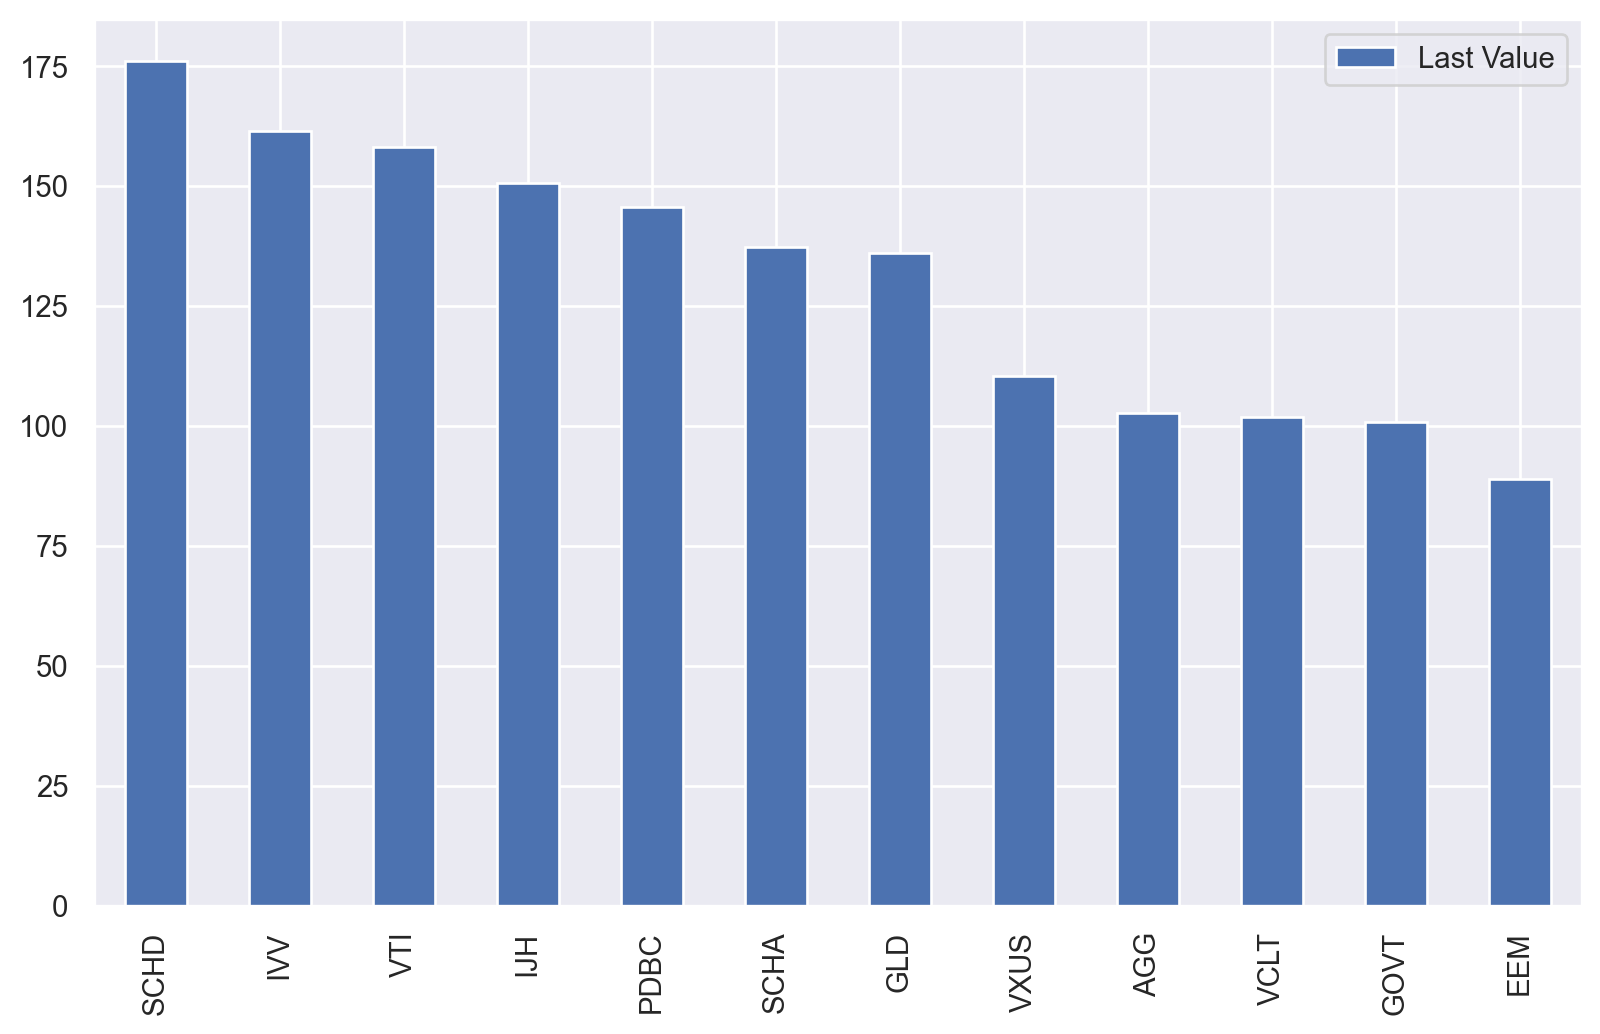

In [6]:
#collapse-hide

# Normalise to 100
normalised_data = (df/df.iloc[0, ]*100)

# A bit of data wrangling
transposed_data = normalised_data.tail(1).reset_index().transpose()
transposed_data = transposed_data.iloc[1:len(transposed_data)]
transposed_data = transposed_data.rename(columns={0: "Last Value"})

# We want a bar chart sorted by decreaseing values
transposed_data = transposed_data.sort_values(by="Last Value", ascending=False)

# Theming Seaborn results
sns.set_theme()

# Draw
transposed_data.plot.bar(figsize=(10, 6))
pass

### Draw the **wealth curve**

The table above is useful, but when it comes to grasping and long term risks and returns, a chart is worth a thousand words.

A very common issue when charting multiple time series is the very different stock levels, and this can make the chart hard to read.

This is why we will once again normalise the data. 

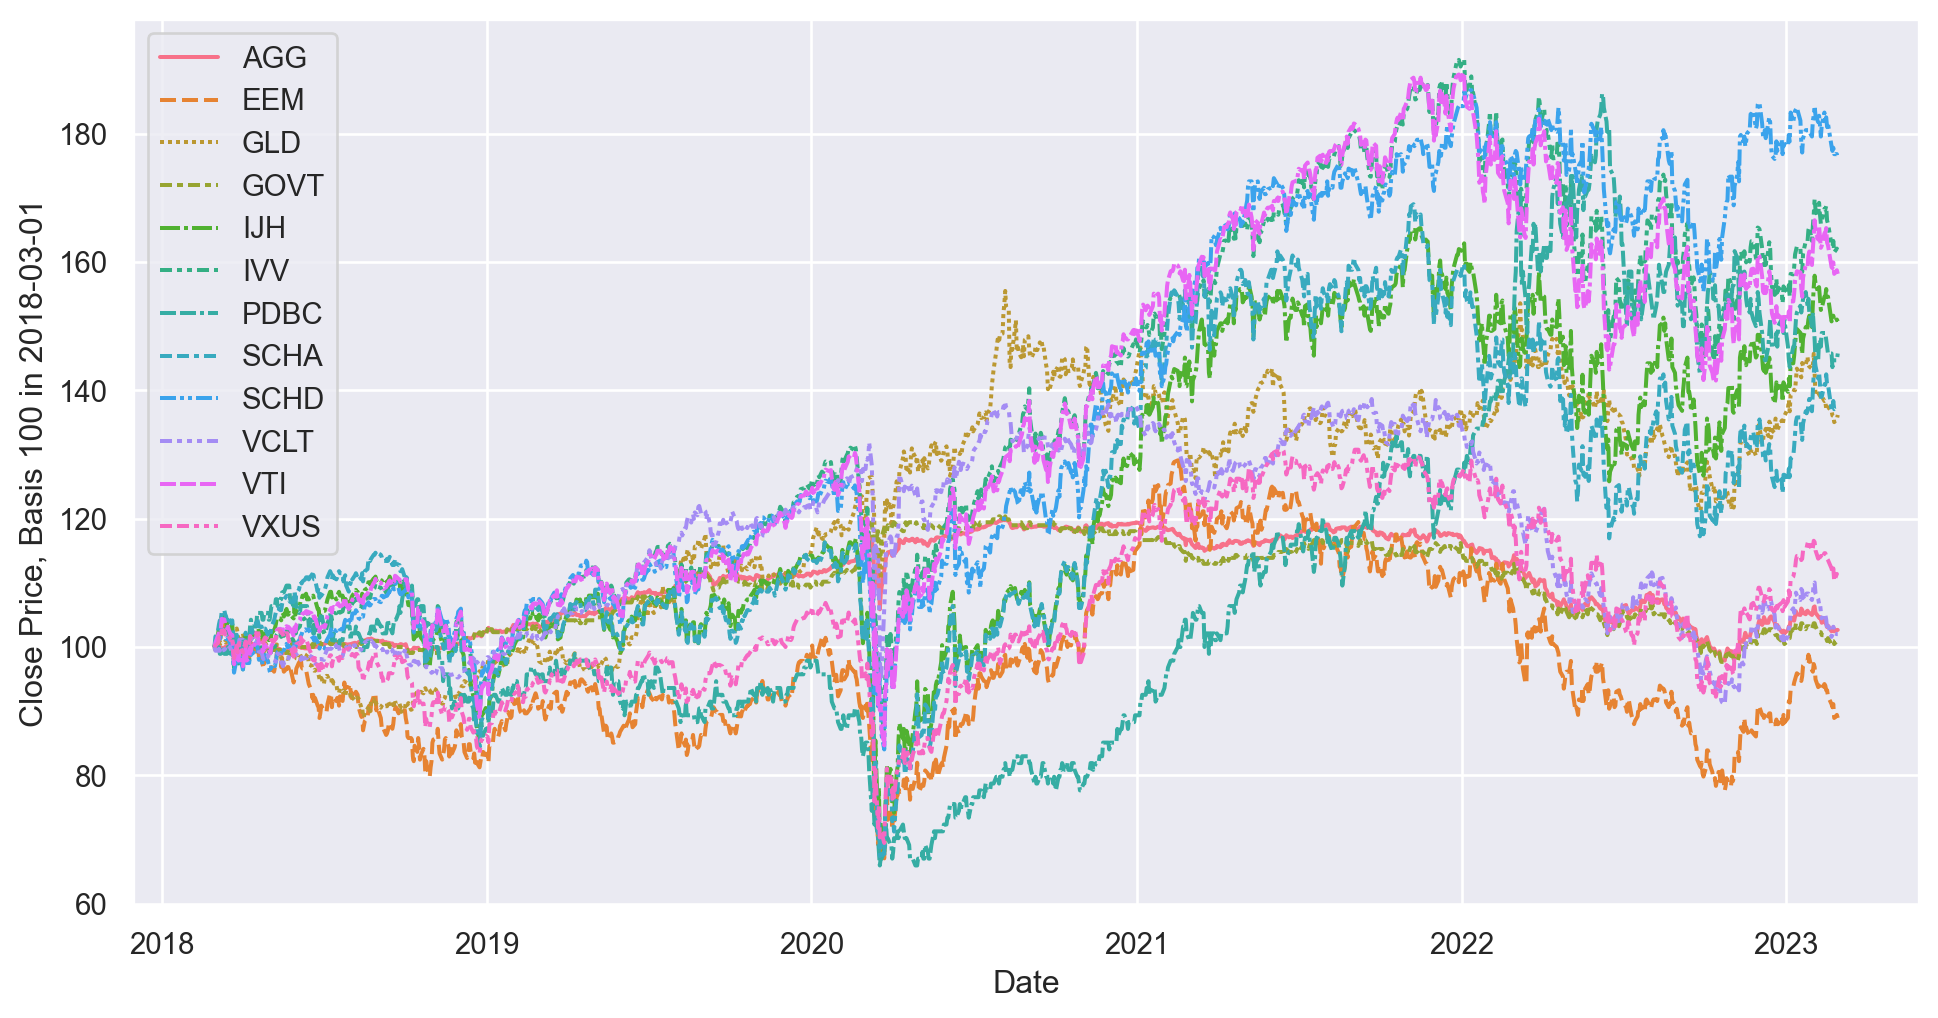

In [7]:
#collapse-hide

# Theming Seaborn results
sns.set_theme()

# Plot the time series
plt.figure(figsize=(12,6))

# Legends and Axis titles
p = sns.lineplot(data=normalised_data)
p.set_ylabel(f"Close Price, Basis 100 in {start_date}")
pass

## Estimate risk and return

In <u>Markowitz 1952</u>, the optimal portfolio is obtained as a function of *expected* returns and *expected* risks of the portfolio. This takes a strong assumption that we have a "crystal ball", or at least access to a predictive model, which at this stage is well beyond this article.

For this first example, we will rely on historical parameters estimation, which precisely means that we expect the past to be a good prediction of what might happen in the future. 

### Volatility

There are many ways to estimate the volatility, and I will only cover the simplest approach. 

We have access to daily close prices of the ETFs, hence we could look at the standard deviation of **daily** returns. In theory this would utilise most of the data we have access to, which is a good thing. In practice, and especially when looking at asset classes which can be observed with an **8 to 12 hours** time difference which might lead the "sample volatility" to become inconsistent between 2 asset classes. This is even more important for estimating the **correlation**.

Practitioners often use **weekly returns** to alleviate this issue, and we will do the same here, and as such calculate the returns using a *resampled* time series. To calculate the **annualized volatility** requires an additional factor in this case the square root of 52. Why this? 

Volatility is essential to option traders, and when pricing options, practitioners often model asset prices as **Wiener processes**(number of weeks in a year) [^3]. The variance of a Wiener process is proportional to the time, and the volatility is the square root of the the variance, which gives us that to convert standard deviation of weekly returns into an *annualized* figure, we need to multiply our results by the square root of the number of weeks in a year.



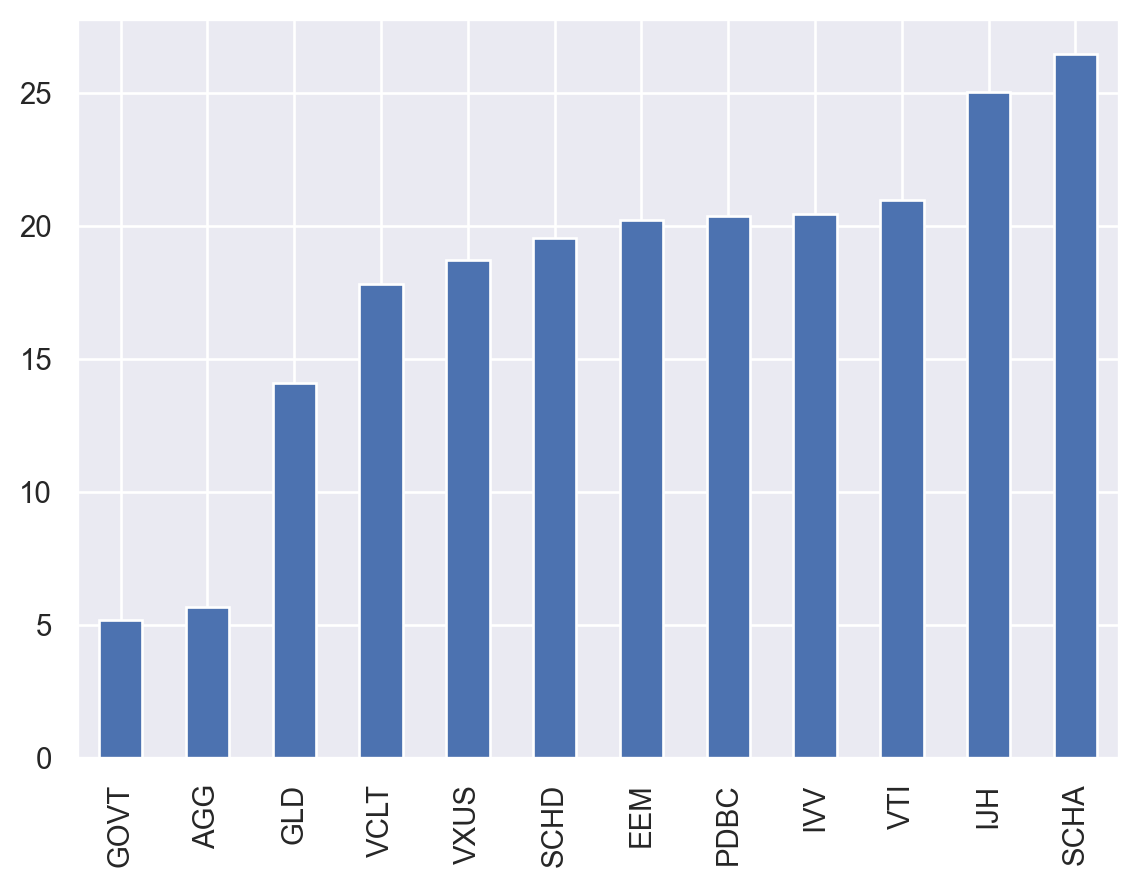

In [8]:
weekly_returns = df.resample("W").last().pct_change()
((weekly_returns.std()*math.sqrt(52)*100).sort_values()).plot.bar();

As one could have guessed, on the left of the chart above, we can find the low volatility asset classes (e.g. Government Bonds, Investment Grade Bonds), whereas on the right we have high volatility asset classes (Mid Cap and Small Cap Equities).

## Correlation

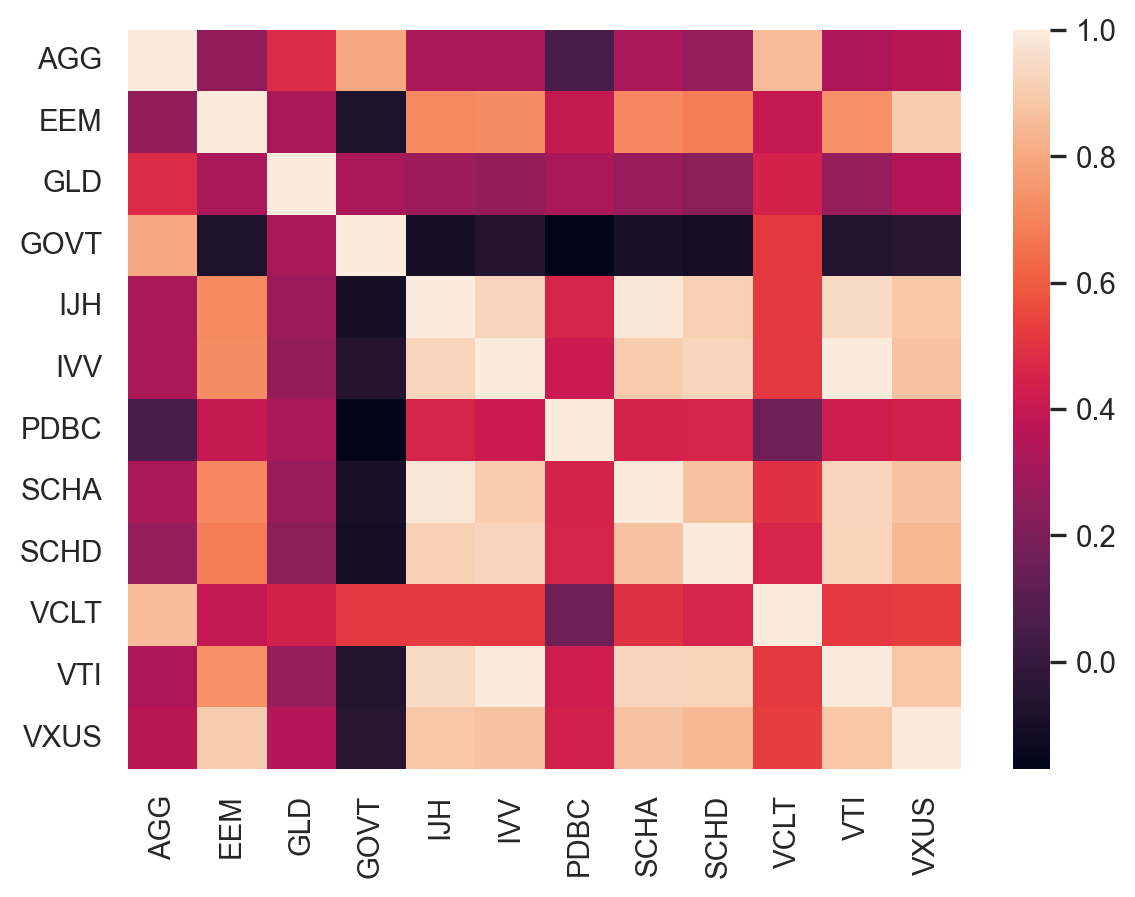

In [9]:
sns.heatmap(weekly_returns.corr());

In [10]:
#collapse-hide
from pypfopt import risk_models
from pypfopt import plotting

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
sample_cov = risk_models.sample_cov(df, frequency=252)

S = risk_models.CovarianceShrinkage(df).ledoit_wolf()

## The main results: Efficient Frontier & Maximum Sharpe Portfolio

### Calculate and draw the efficient frontier

With expected returns and risk estimated, we are ready to utilise PyPortfolioOpt's optimiser to draw the **efficient frontier**.

The idea behind the efficient frontier is relatively simple: 
- For **each level of investor's risk**, there is an optimal portfolio which is expected to deliver the **highest level of return**; or conversely
- For **each level of investor's return**, there is an optimal portfolio which is expected to deliver the **lowest level of return**.

/opt/homebrew/Caskroom/miniconda/base/envs/portfolio-geek/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


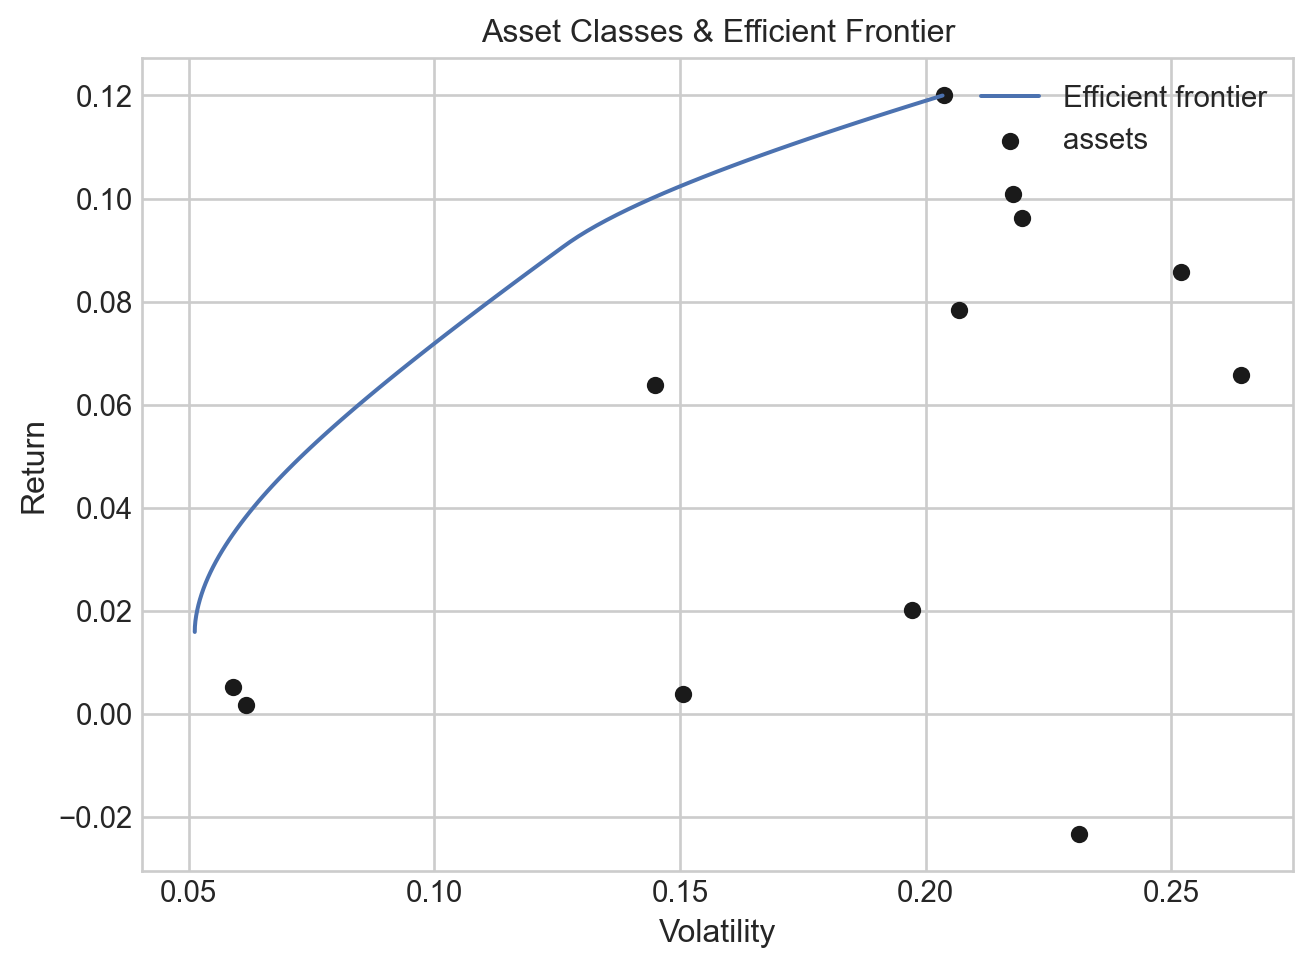

In [11]:
#collapse-hide
ef = EfficientFrontier(mu, sample_cov)

# We create 2 efficient frontiers
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
ax.set_title("Asset Classes & Efficient Frontier")

plt.show()

### Add the Maximum Sharpe portfolio

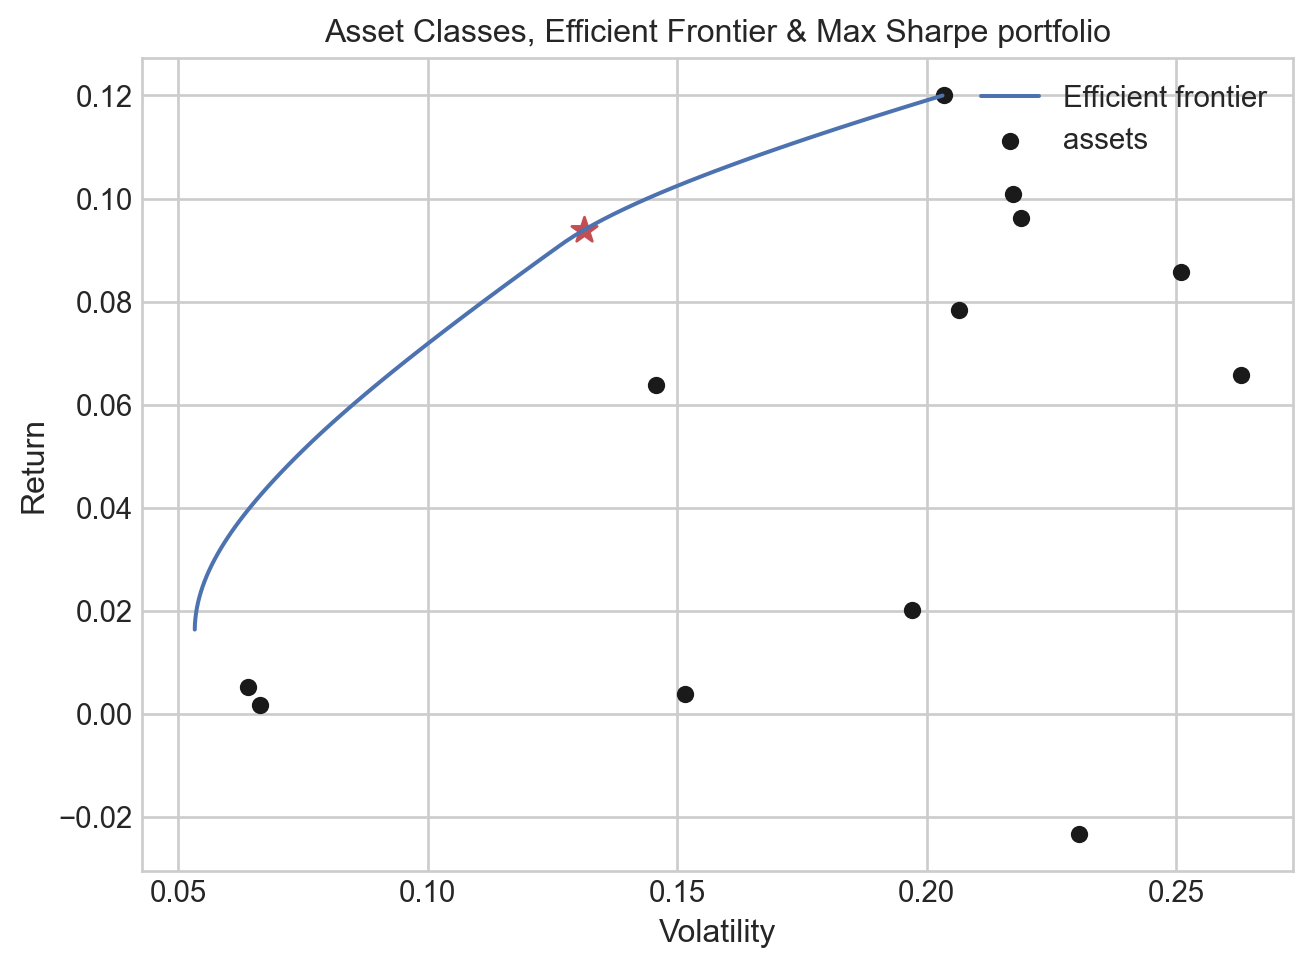

In [12]:
#collapse-hide

# Find and plot the tangency portfolio
fig2, ax = plt.subplots()
ef2 = EfficientFrontier(mu, S) 
plotting.plot_efficient_frontier(ef2, ax=ax, show_assets=True)

ef3 = EfficientFrontier(mu, S) 

ef3.max_sharpe()
ret_tangent, std_tangent, _ = ef3.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")
ax.set_title("Asset Classes, Efficient Frontier & Max Sharpe portfolio")
plt.show()

### Calculate random portfolios

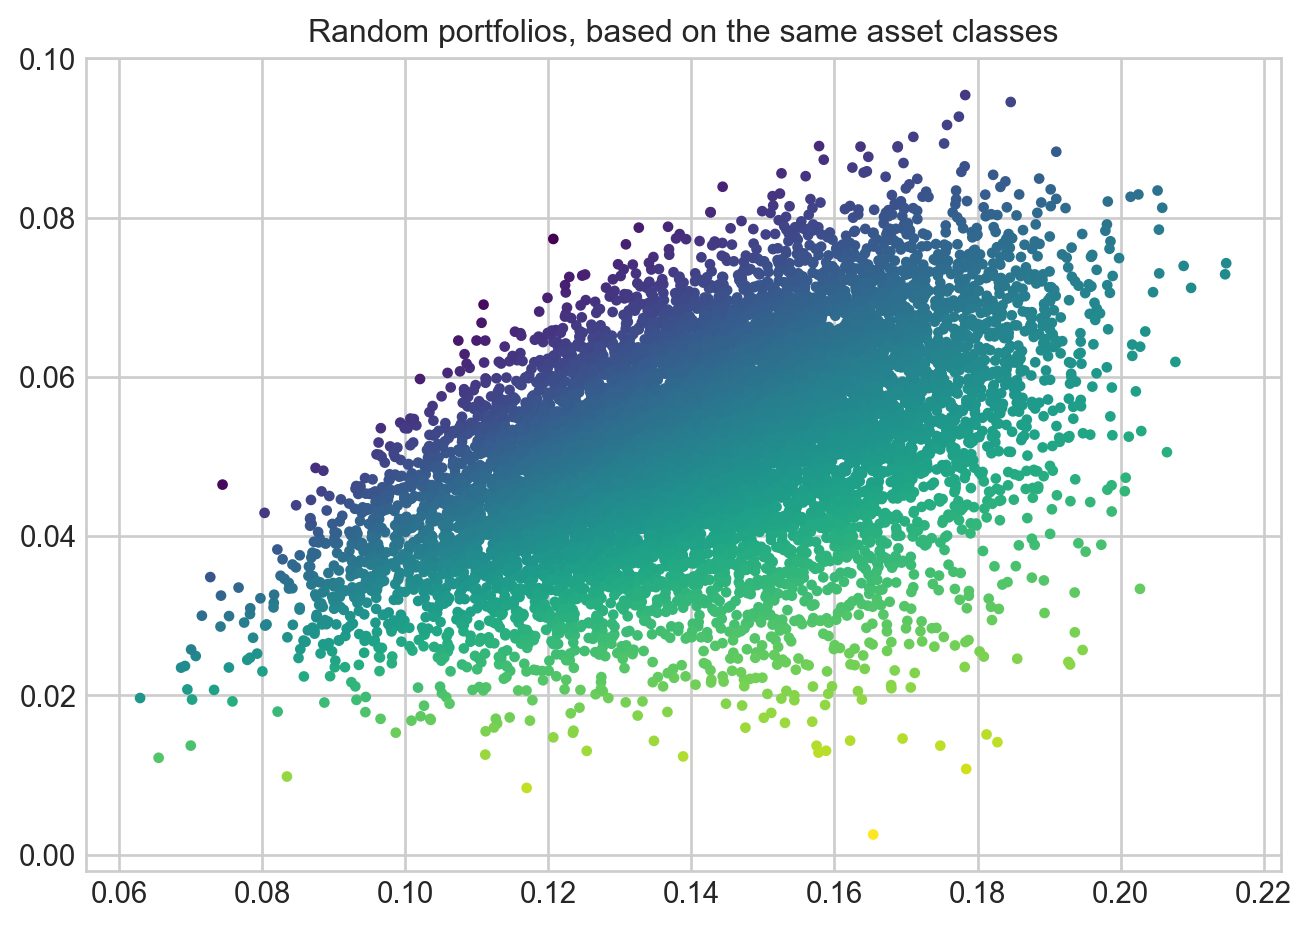

In [13]:
#collapse-hide

# Plot random portfolios
fig2, ax = plt.subplots()
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Random portfolios, based on the same asset classes")
#ax.legend()
plt.tight_layout()
plt.show()

## Conclusion

Et voila!

Compared to macros or Excel formulas, this is an amazing improvement, and enables us to customise everything in seconds: historical timeframe, asset classes, etc.

To deliver a full portfolio optimisation process in such a limited number of lines is truly awesome.

I hope this article provided you some ideas on how to look at portfolio construction.

Happy coding, and happy portfolio construction!



[^1]: [Portfolio Selection](https://www.jstor.org/stable/2975974), Henri Markowitz, 1952

[^2]: [PyportfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/), Robert Andrew Martin, 2018

[^3]: [Wikipedia.com / Wiener Processes](https://en.wikipedia.org/wiki/Wiener_process)